In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from memory_profiler import memory_usage
from scipy.optimize import curve_fit
from pathos.multiprocessing import Pool
from itertools import product

# Algorithmic Data Science Project

## 1. Introduction

In this Jupyter notebook we explored different implementations of square matrix multiplication. Focusing on the naive and Strassen's methods. Both of these were evaluated using a series of experiments such as runtime measurements and investigations of the time complexity for our implementations on the available machinery. Sections 2. and 3. are related to the naive and Strassen's methods respectively. Next, we looked into how much memory is utilised by the machine when performing matrix multiplication. In section 5. we compared the performance of our algorithms and discussed where it might be more beneficial to use ehich method of multiplication. Lastly, section 6. investigated a possible implementation of the MapReduce method with naive matrix multiplication.

## 2. Naive method of matrix multiplication

The run-time of the naive method of matrix multiplication is $O(n^3)$ because it uses three nested loops. As seen in the code of the *naive_square_matrix_multiplication* function in the cell below, the first loop $i$ goes from 1 to $n$. Similarly, the second and third loops go from 1 to $n$ for $j$ and $k$. In other words, given two $n \times n$ matrices, all three loops will run $n$ times. The first loop calculates the rows of the new matrix, the second loop calculates the columns of the new matrix, and the third loop calculates the dot product which will become a value in the new matrix. Since additions do not influence asymptotic behaviour, each loop contributes a factor of $n$ to the number of operations. In total, this gives $n * n * n = n^3$ operations. Resulting in the run-time being $O(n^3)$.

In [3]:
def naive_square_matrix_multiplication(A, B):
    """
    Given square matrices A and B, multiplies the two using the naive multiplication method.
    Adapted from lab notebooks.
    """
    
    n = len(A)
    C = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i][j] += A[i][k] * B[k][j]
    
    return C

def naive_runtime(sizes, runs):
    """
    Measures the runtime in seconds of the naive matrix multiplication method, utilizing the naive_square_matrix_multiplication function. Does so over repeated runs to calculate 
    mean value and standard deviation for each matrix size.
    sizes is an array containing sizes of square arrays that will be used for multiplication
    runs specifies how many times to measure time for one size
    """
    mean_times = []
    std_devs = []

    for i in sizes :
        run_times = []
        for _ in range(runs):
            #Initializes two matrices with random values of size currently used by the loop
            A = np.random.rand(i, i)
            B = np.random.rand(i, i)

            #Measures time taken to complete matrix multiplication
            start_time = time.time()
            naive_square_matrix_multiplication(A, B)
            end_time = time.time()

            run_times.append(end_time - start_time)

        mean_time = np.mean(run_times)
        mean_times.append(mean_time)
        
        std_dev = np.std(run_times)
        std_devs.append(std_dev)

        print(f"Matrix size: {i}x{i}, mean time; {mean_time:.5f} s, standard deviation: {std_dev:.5f} s")

    return mean_times, std_devs




In order to empirically test whether run-time of naive matrix multiplication is $O(n^3)$ we will use the *naive_runtime* function, implemented in the cell above, to perform naive matrix multiplication on a arrays of increasing size. *naive_runtime* measures the time it takes to complete matrix multiplication over a desired number of runs. In most cases, we will look at instances where 10 runs were completed for each matrix size. For each size, *naive_runtime* calculates the mean value and standard deviation. To save time, the largest matrix size of $1000 \times 1000$ will be calculated once. Please note that these run times will vary between machines due to differences in hardware capabilities. 

In [4]:
#Initializes an array with desired sizes and specifies how many runs to complete at each size
sizes = [10, 20, 50, 75, 100, 150, 200, 300, 400, 500]

runs = 5

mean_times, std_devs = naive_runtime(sizes, runs)

Matrix size: 10x10, mean time; 0.00070 s, standard deviation: 0.00003 s
Matrix size: 20x20, mean time; 0.00446 s, standard deviation: 0.00047 s
Matrix size: 50x50, mean time; 0.04858 s, standard deviation: 0.00226 s
Matrix size: 75x75, mean time; 0.15732 s, standard deviation: 0.00197 s
Matrix size: 100x100, mean time; 0.36749 s, standard deviation: 0.00216 s
Matrix size: 150x150, mean time; 1.23787 s, standard deviation: 0.00505 s
Matrix size: 200x200, mean time; 2.92386 s, standard deviation: 0.01174 s
Matrix size: 300x300, mean time; 10.05799 s, standard deviation: 0.05119 s
Matrix size: 400x400, mean time; 24.11208 s, standard deviation: 0.08632 s
Matrix size: 500x500, mean time; 46.79218 s, standard deviation: 0.26493 s


In [5]:
size = [1000]
run = 1

times, std = naive_runtime(size, run)

Matrix size: 1000x1000, mean time; 388.20712 s, standard deviation: 0.00000 s


In [6]:
sizes.append(size[0])
mean_times.append(times[0])
std_devs.append(std[0])

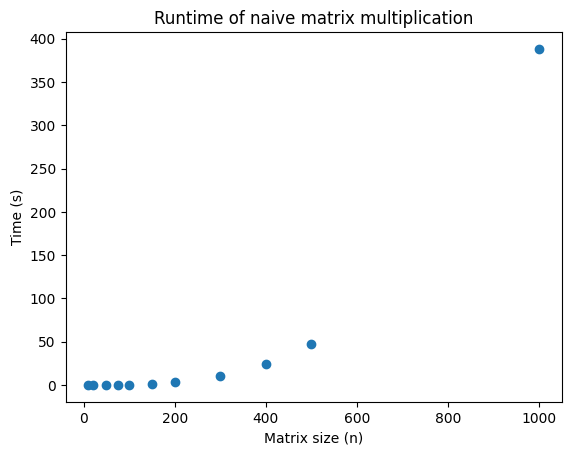

In [7]:
plt.errorbar(sizes, mean_times, yerr = std_devs, fmt = "o")
plt.xlabel("Matrix size (n)")
plt.ylabel("Time (s)")
plt.title("Runtime of naive matrix multiplication")
plt.show()

Between the above implementation and the machine this code was calculated with, we can see that for a $10 \times 10$ aray the average multiplication time was $0.00070$ seconds. On the other hand, a calculation of the $1000 \times 1000$ array took $388.207$ seconds. Nearly six and a half minutes! Moreover, as we may see in the graph in the cell above, the run time of naive matrix multiplication appears to be following a cubic relationship. However, to test this further we are going fit a cubic polynomial to the generated data and assess its fit.

In [8]:
#Fits a cubic polynomial
coefficients = np.polyfit(sizes, mean_times, 3)
cubic = np.poly1d(coefficients)

#Generates predictions
predicted_times = cubic(sizes)

#Calculates R^2
r2 = r2_score(mean_times, predicted_times)

print(f"R^2: {r2:.3f}")

R^2: 1.000


The calculated $R^2$ value when fitting a cubic is equal to 1. Proving the cubic nature of the relationship seen in the graph above. That said, the small sizes of arrays used to calculate this fit are a limiting factor. Given a larger amount of data, the correlation coefficient should decrease slightly, still signifying a very strong correlation. To argue for further, when checking this data for a quadratic correlation, we get a $R^2$ value of $0.997$. This still means a very strong correlation, but if the data was quadratic in nature the coefficint would be 1. Checking for a linear correlation gives $R^2$ of 0.803.

Our final task related to naive matrix multiplication is determining the key constant in the run-time formula. Using our empirical data and the formula $t(n) = c * n^3$ we can estimate $c$ in the following way: $$c \approx \frac{t(n)}{n^3}$$ The code in the cell below will calculate $c$ for different matrix sizes, and finally take the average.

In [9]:
constants = []

for i, j in enumerate(sizes):
    t_n = mean_times[i]
    c = t_n / (j**2)
    constants.append(c)

for i, j in zip(sizes, constants):
    print(f"For a matrix of size {i}x{i}, the estimated constant c is equal to {j:.3g}")

average_constant = sum(constants) / len(constants)
print(f"\nAverage estimated constant c: {average_constant:.3g}")


For a matrix of size 10x10, the estimated constant c is equal to 7.04e-06
For a matrix of size 20x20, the estimated constant c is equal to 1.12e-05
For a matrix of size 50x50, the estimated constant c is equal to 1.94e-05
For a matrix of size 75x75, the estimated constant c is equal to 2.8e-05
For a matrix of size 100x100, the estimated constant c is equal to 3.67e-05
For a matrix of size 150x150, the estimated constant c is equal to 5.5e-05
For a matrix of size 200x200, the estimated constant c is equal to 7.31e-05
For a matrix of size 300x300, the estimated constant c is equal to 0.000112
For a matrix of size 400x400, the estimated constant c is equal to 0.000151
For a matrix of size 500x500, the estimated constant c is equal to 0.000187
For a matrix of size 1000x1000, the estimated constant c is equal to 0.000388

Average estimated constant c: 9.71e-05


## 3. Strassen's method of matrix multiplication

In general, Strassen's method of matrix multiplication is apsymtotically faster than the naive method, because it reduces the number of multiplications required to obtain the resultant matrix from 8 to 7. When multiplying two $n \times n$ matrices where $n$ is a power of two, this algorithm recursively breaks down the operation into multiplication of $\frac{n}{2} \times \frac{n}{2}$ matrices. In other words, by breaking down the initial matrices into smaller ones and recursively applying multiplication, addition and subtraction, Strassen's algorithm reduces the total amount of multiplications necessary to calculate the resultant matrix by one. This reduces the time complexity of the algorithm compared to the naive method because it uses a divide-and-conquer approach. By splitting the calculation into smaller problems and combining the result at the end.

We will now assume that Strassen's method has time complexity of the form $O(n^a). As such, we can write the run-time formula for this algorithm as $$t(n) = c * n^a$$ 
Where $t(n)$ is the time it took to multiply two matrices sized $n \times n$, $c$ is a costant that depends on how an algorithm was implemented and the machine it ran on, and $a$ is the exponent we wish to etimate.

In order to estimate $a$ we take the logarithm of both sides of the equation above: $$log(t(n)) = log(c * n^a)$$
This can be rewritten as: $$log(t(n)) = log(c) + a * log(n)$$
Which resembles the form of a linear equation. Indeed, the left hand side of the above equation would be $y$, $log(n)$ is the variable $x$, $log(c)$ is a constant, which represents the vertical-axis intercept, and finally $a$ is the slope of the line. By carrying out matrix multiplications using Strassen's method and measuring the time it takes and taking logarithms of these values, we may fit a straight line to the points we obtain. The slope of this line will give us an estimate of the value of a. Code in the cell below implements Strassen's method, a way to measure run time and a way to estimate a.

In [10]:
def strassen_matrix_multiplication(A, B):
    """
    Multiplies two n by n matrices using Strassen's method, where n is a power of 2.
    Adapted from lab notebooks
    """
    n = len(A)

    # Base case for 1x1 matrix
    if n == 1:
        return A * B
    
    # Splits matrices into four submatrices
    middle = n // 2
    a = A[:middle, :middle]
    b = A[:middle, middle:]
    c = A[middle:, :middle]
    d = A[middle:, middle:]

    e = B[:middle, :middle]
    f = B[:middle, middle:]
    g = B[middle:, :middle]
    h = B[middle:, middle:]

    # Multiplications
    M1 = strassen_matrix_multiplication(a, f - h)
    M2 = strassen_matrix_multiplication(a + b, h)
    M3 = strassen_matrix_multiplication(c + d, e)
    M4 = strassen_matrix_multiplication(d, g - e)
    M5 = strassen_matrix_multiplication(a + d, e + h)
    M6 = strassen_matrix_multiplication(b - d, g + h)
    M7 = strassen_matrix_multiplication(a - c, e + f)

    # Combines results
    r = M5 + M4 - M2 + M6
    s = M1 + M2
    t = M3 + M4
    u = M5 + M1 - M3 - M7

    # Builds the result
    C = np.zeros((n, n))
    C[:middle, :middle] = r
    C[:middle, middle:] = s
    C[middle:, :middle] = t
    C[middle:, middle:] = u

    return C

def strassen_runtime(sizes, runs):
    """
    Measures the runtime in seconds of the SDtrassen matrix multiplication method, utilizing the strassen_matrix_multiplication function. Does so over repeated runs to calculate 
    mean value and standard deviation for each matrix size.
    sizes is an array containing sizes of square arrays that will be used for multiplication
    runs specifies how many times to measure time for one size
    """

    mean_times = []
    std_devs = []

    for i in sizes :
            run_times = []

            for _ in range(runs):
                #Initializes two matrices with random values of size currently used by the loop
                A = np.random.rand(i, i)
                B = np.random.rand(i, i)

                #Measures time taken to complete matrix multiplication
                start_time = time.time()
                strassen_matrix_multiplication(A, B)
                end_time = time.time()

                run_times.append(end_time - start_time)

            mean_time = np.mean(run_times)
            mean_times.append(mean_time)
            
            std_dev = np.std(run_times)
            std_devs.append(std_dev)

            print(f"Matrix size: {i}x{i}, mean time; {mean_time:.5f} s, standard deviation: {std_dev:.5f} s")

    return mean_times, std_devs

def estimate_a(sizes, mean_times):
     """
     Estimates a by applying log transformations to both sides of the run-time formula and applying a linear regression to it. in that context, a will be the slope of the fitted line.
     sizes is an array containing sizes of arrays
     mean_times are average times it took to calculate matrix multiplication using Strassen's method
     """
     log_sizes = np.log(sizes)
     log_times = np.log(mean_times)

     #Applies a linear fit to find a
     a, _ = np.polyfit(log_sizes, log_times, 1)
     print(f"Estimated value of a: {a:.5f}")

     return a


In [11]:
#Initializes an array with desired sizes and specifies how many runs to complete at each size. The number of runs has been decreased to speed up the process
sizes2 = [4, 8, 16, 32, 64, 128, 256, 512]
runs2 = 5

#Measures and calculates mean run time and standard deviation
mean_strassen, stds_strassen = strassen_runtime(sizes2, runs2)

Matrix size: 4x4, mean time; 0.00029 s, standard deviation: 0.00012 s
Matrix size: 8x8, mean time; 0.00119 s, standard deviation: 0.00022 s
Matrix size: 16x16, mean time; 0.00538 s, standard deviation: 0.00037 s
Matrix size: 32x32, mean time; 0.03253 s, standard deviation: 0.00016 s
Matrix size: 64x64, mean time; 0.22915 s, standard deviation: 0.00690 s
Matrix size: 128x128, mean time; 1.58165 s, standard deviation: 0.01002 s
Matrix size: 256x256, mean time; 11.06946 s, standard deviation: 0.01164 s
Matrix size: 512x512, mean time; 77.53999 s, standard deviation: 0.06427 s


In [12]:
#Estimates a
a = estimate_a(sizes2, mean_strassen)

Estimated value of a: 2.61352


The estimated value of $a$ within this implementation and on machinery used to calculate this is equal to 2.61352, as seen in the cell above. The expected value is 2.81, but this discrepancy could be due to the sample size used for calculations and our environment (the value of 2.81 was taken from lecture notes). 

Now that we obtained an estimate of $a$, we are able to estimate the key constant in the run-time formula by rearranging it as follows: $$c = \frac{t(n)}{n^a}$$
The code cell below estimates the key constant for different array sizes and then gives an average value.

In [45]:
def constants_strassen(sizes, mean_time, a):
    """
    Calculates estimates of key constant of Strassen's method's run-time formula for different matrix sizes using the estimated value of a.
    """

    constants = []

    for i, j in enumerate(sizes):
        t_n = mean_time[i]
        c =  t_n / (j**a)

        constants.append(c)

        print(f"For a matrix of size {j}x{j}, the estimated constant c is equal to {c:.3g}")

    #Calculates average constant
    average_constant = np.mean(constants)
    print(f"\nAverage estimated constant c: {average_constant:.3g}")

    return constants, average_constant

In [46]:
#Estimates key constants and calcuates average
constants_str, average_constant_str = constants_strassen(sizes2, mean_strassen, a)

For a matrix of size 4x4, the estimated constant c is equal to 7.75e-06
For a matrix of size 8x8, the estimated constant c is equal to 5.18e-06
For a matrix of size 16x16, the estimated constant c is equal to 3.84e-06
For a matrix of size 32x32, the estimated constant c is equal to 3.79e-06
For a matrix of size 64x64, the estimated constant c is equal to 4.36e-06
For a matrix of size 128x128, the estimated constant c is equal to 4.92e-06
For a matrix of size 256x256, the estimated constant c is equal to 5.63e-06
For a matrix of size 512x512, the estimated constant c is equal to 6.44e-06

Average estimated constant c: 5.24e-06


# 4. Memory usage

Let us first measure memory usage of the above implementations of the naive and Strassen's methods of matrix multiplication. 

In [96]:
def measure_memory(size, method):
    """
    Given an array size and with multiplication method specified measures maximum memory usage.
    size is an integer
    method is a string, either "naive" or "strassen"
    """

    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    if method == "naive":
        usage = memory_usage((naive_square_matrix_multiplication, (A, B)), interval = 0.5)
    elif method == "strassen":
        usage = memory_usage((strassen_matrix_multiplication, (A, B)), interval = 0.5)

    return max(usage)

In [97]:
#Compares memory usage of the two methods

#Initializes variables and storage arrays
matrix_sizes = [8, 16, 32, 64, 128, 256, 512]
naive_memory = []
strassen_memory = []

#Iterates over sizes for matrix_sizes
for i in matrix_sizes:
    naive_usage = measure_memory(i, "naive")
    strassen_usage = measure_memory(i, "strassen")

    naive_memory.append(naive_usage)
    strassen_memory.append(strassen_usage)

    print(f"Matrix size: {i}x{i}")
    print(f"Naive method max memory usage: {naive_usage} MB")
    print(f"Strassen's method max memory usage: {strassen_usage} MB")


Matrix size: 8x8
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 16x16
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 32x32
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 64x64
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 128x128
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 256x256
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB
Matrix size: 512x512
Naive method max memory usage: 378.046875 MB
Strassen's method max memory usage: 378.046875 MB


The test above has shown that each run used the same amount of memory. This result may seem unexpected at first. However, a possible explanation is that the way our environment assigns memory to the coding editor. A set amount is provided, then if the editor shows signs of running out, it gets assigned more as necessary. 

In general, Strassen's method has a higher memory requirement compared to the naive method. As mentioned before, the naive method utilizes three nested loops when multiplying two matrices, which produces a third matrix. As such, memory is used mainly to store these matrices. Since all of them are $n \times n$ we get three instances of $O(n^2)$ space, meaning the space complexity is the same.

On the other hand, since Strassen's method uses the aforementioned divide-and-conquer approach for its multiplication. The two initial matrices are split into four submatrices which are then recursively multiplied. On top of that, as we have seen in the *strassen_matrix_multiplication* function, seven auxiliary matrices for multiplications, additions and subtractions. results need to be stored at each level of this recursive operation as more temporary matrices are required. Following a similar logic to the naive method, the memory space of Strassen's method is approximately $O(n^{2.81})$. 

In summary, the naive method is better when it comes memory usage. Strassen's method comes with a trade-off between a potentially faster run time for large matrices and a higher memory requirement. Which make the latter less ideal in memory-limited scenarios.

## 5. Usage of the naive and Strasssen's matrix multiplication methods

By plotting the results obtained from previous tests, we will compare the performance of our implementations of both and later discuss where it might be beneficial to use each of these methods. 

<function matplotlib.pyplot.show(close=None, block=None)>

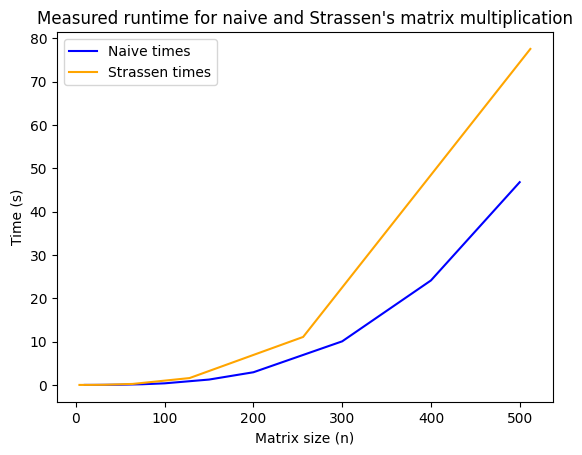

In [66]:
plt.plot(sizes[: -1], mean_times[: -1], "-", color = "b", label = "Naive times")
plt.plot(sizes2, mean_strassen, "-", color = "orange", label = "Strassen times")

plt.xlabel("Matrix size (n)")
plt.ylabel("Time (s)")
plt.title("Measured runtime for naive and Strassen's matrix multiplication")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

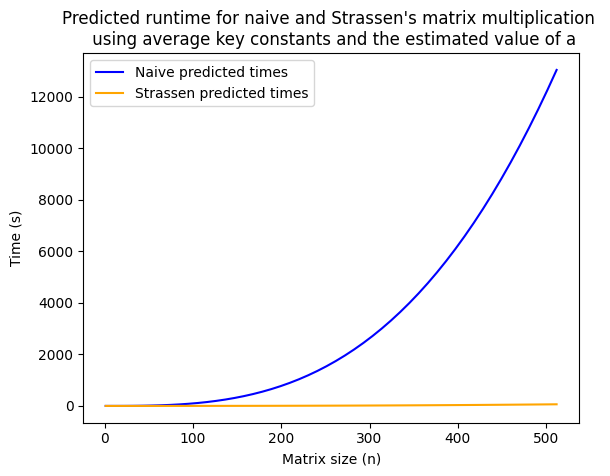

In [56]:
n_values = np.linspace(1, 512)

naive_values = average_constant * n_values**3
strassen_values = average_constant_str * n_values**a

plt.plot(n_values, naive_values, "-", color = "b", label = "Naive predicted times")
plt.plot(n_values, strassen_values, "-", color = "orange", label = "Strassen predicted times")

plt.xlabel("Matrix size (n)")
plt.ylabel("Time (s)")
plt.title("Predicted runtime for naive and Strassen's matrix multiplication \n using average key constants and the estimated value of a")
plt.legend()
plt.show

In [57]:
n_values2 = np.linspace(1, 512)

naive_values2 = 7.04e-06 * n_values**3
strassen_values2 = 7.75e-06 * n_values**2.81

<function matplotlib.pyplot.show(close=None, block=None)>

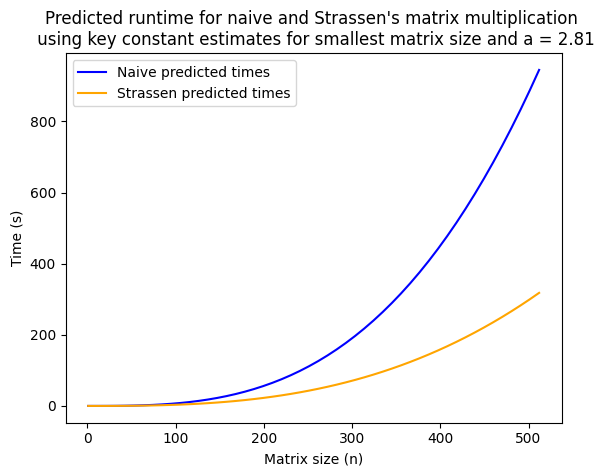

In [59]:
plt.plot(n_values2, naive_values2, "-", color = "b", label = "Naive predicted times")
plt.plot(n_values2, strassen_values2, "-", color = "orange", label = "Strassen predicted times")

plt.xlabel("Matrix size (n)")
plt.ylabel("Time (s)")
plt.title("Predicted runtime for naive and Strassen's matrix multiplication \n using key constant estimates for smallest matrix size and a = 2.81")
plt.legend()
plt.show

Interestingly, as we may see in the plots above, within our implementation of both multiplication methods, Strassen's takes longer. However, when using the estimated values such as key-constants and the exponent a, we see that the predicted time of the naive method is always longer. 

In theory, since Strassen's method has time complexity $O(n^{2.81})$, against the naive method's $O(n^3)$, it will be the better method to use. Especially once large arrays are operated on. However, there is a case to be made when we are limited by the amount of memory available. The naive method is simple to implement, and most importantly requires fewer items being stored while the multiplication is carried out. So in environments where memory is the bottleneck, Strassen's method might not be the desirable approach. There are two other factors worth mentioning. With high-performance machinery, the Strassen method might be parallelised, increasing its efficiency further. Lastly, the naive method relies on a smaller number of operations, which means it will introduce fewer rounding errors.

## 6. Naive method of matrix multiplication using MapReduce

MapReduce is a computing paradigm that was developed by Google in 2004. It requires two function to opearate: *map()* and *reduce()*. The former function is responsible for separating input data into smaller pieces. These pieces are then sorted based on keys they were assigned during the mapping process. The latter function operates on a group sharing a key. What this process enables is working in parallel on a larger network of machines. This way, data-processing on a large scale can be done more efficiently. However, truly large datasets will benefit from MapReduce's benefits.

In order to simulate MapReduce, we are going to use the *pathos* module. It will allow for running operations in parallel on a single machine. The code cells below implement *map()* and *reduce()* functions and a method to perform naive matrix multiplication. 

In [18]:
def Map(data_piece):
    """
    Takes in a piece of data which includes i, j, k indices and matrices A and B.
    It calculates the product A[i][k] times B[k][j] and returns a key-value pair of (i, j) and the multiplication result.
    """

    i, j, k, A, B = data_piece
    return ((i, j), A[i][k] * B[k][j])

def Reduce(data):
    """
    Takes a list of key-value pairs (produced by the map() function) and sums the values for each key.
    A key is (i, j), responding to elements of the calculated matrix (the result of multiplication).
    """

    result = {}
    
    for i, j in data:
        if i not in result:
            result[i] = 0
        result[i] += j

    return result

def mapreduce_multiplication(A, B):
    """
    Utilizing the Map() function, simulates parallel computing to then reduce the key-value pairs and finally obtain the result of matrix multiplication.
    A and B are two n by n matrices to be multiplied. 
    """

    n = len(A)

    #Creates a list of data pices that will be fed to the map() funtction
    data_pieces = [(i, j, k, A, B) for i, j, k in product(range(n), range(n), range(n))]

    #Uses pathos.multiprocessing to simulate parallel computing
    with Pool() as pool:
        data = pool.map(Map, data_pieces)

    #Reduces mapped data
    reduced = Reduce(data)

    #Creates result
    C = np.zeros((n, n))
    for (i, j), k in reduced.items():
        C[i][j] = k

    return C

In [19]:
M = np.array([[3, 5], [12, 1]])
N = np.array([[7, 9], [3, 21]])

O = mapreduce_multiplication(M, N)

print(f"The result of multiplying matrix M by N is:")
print(O)

The result of multiplying matrix M by N is:
[[ 36. 132.]
 [ 87. 129.]]


Initially we attempted to simulate parallel running using the *multiprocessing* module. These attempts were unsuccessful and kept raising an *AttributeError*. After some consideration the module used was changed to *pathos* which works better within Jupyter notebooks. 

Next, we will time the implemented matrix multiplication which uses MapReduce and compare its performance with the naive method investigated in section 2. above.

In [20]:
def mapreduce_runtime(sizes):
    """
    Measures the runtime in seconds of the naive matrix multiplication method utilizing MapReduce. Uses the implementaion developed earlier in the notebook.
    sizes is an array containing sizes of square arrays that will be used for multiplication and have the time taken to calculate taken
    runs specifies how many times to measure time for one size
    """
    times = []

    for i in sizes :
        
        #Initializes two matrices with random values of size currently used by the loop
        A = np.random.rand(i, i)
        B = np.random.rand(i, i)

        #Measures time taken to complete matrix multiplication
        start_time = time.time()
        mapreduce_multiplication(A, B)
        end_time = time.time()

        times.append(end_time - start_time)

        print(f"Matrix size: {i}x{i}, time: {(end_time - start_time):.5f} s")

    return times

In [22]:
print(sizes[: -3])

[10, 20, 50, 75, 100, 150, 200, 300]


In [23]:
mapreduce_sizes = sizes[:-3]
mapreduce_times = mapreduce_runtime(mapreduce_sizes)

Matrix size: 10x10, time: 0.08474 s
Matrix size: 20x20, time: 0.09903 s
Matrix size: 50x50, time: 0.57794 s
Matrix size: 75x75, time: 1.81406 s
Matrix size: 100x100, time: 4.23671 s
Matrix size: 150x150, time: 14.68048 s
Matrix size: 200x200, time: 35.87101 s
Matrix size: 300x300, time: 126.23136 s


In [24]:
mapreudce_400 = mapreduce_runtime([400])

Matrix size: 400x400, time: 310.05505 s


In [62]:
mapreduce_times = mapreduce_times[: -1]
#mapreduce_sizes.append(400)
mapreduce_times.append(mapreudce_400[0])
print(mapreduce_sizes)
print(mapreduce_times)

[10, 20, 50, 75, 100, 150, 200, 300, 400]
[0.08473610877990723, 0.09903311729431152, 0.5779449939727783, 1.8140621185302734, 4.236709833145142, 14.680476903915405, 35.871005058288574, 126.23135685920715, 310.05505108833313]


<function matplotlib.pyplot.show(close=None, block=None)>

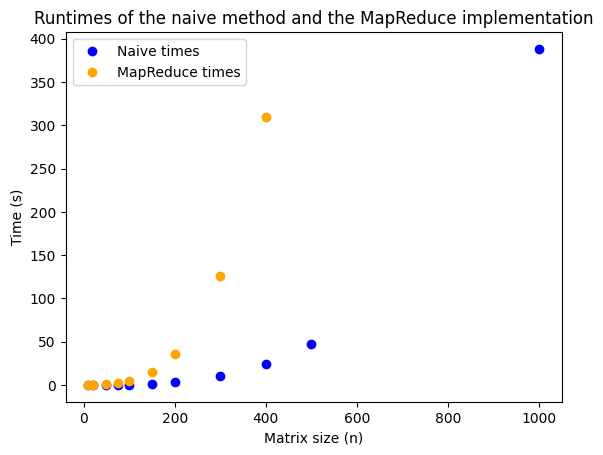

In [67]:
plt.plot(sizes, mean_times, "o", color = "b", label = "Naive times")
plt.plot(mapreduce_sizes, mapreduce_times, "o", color = "orange", label = "MapReduce times")

plt.xlabel("Matrix size (n)")
plt.ylabel("Time (s)")
plt.title("Runtimes of the naive method and the MapReduce implementation")
plt.legend()
plt.show

In [64]:
#Reused from section 2
constants_mapreduce = []

for i, j in enumerate(mapreduce_sizes):
    t_n = mapreduce_times[i]
    c = t_n / (j**2)
    constants_mapreduce.append(c)

for i, j in zip(mapreduce_sizes, constants_mapreduce):
    print(f"For a matrix of size {i}x{i}, the estimated constant c is equal to {j:.3g}")

average_constant_mr = sum(constants_mapreduce) / len(constants_mapreduce)
print(f"\nAverage estimated constant c: {average_constant_mr:.3g}")

For a matrix of size 10x10, the estimated constant c is equal to 0.000847
For a matrix of size 20x20, the estimated constant c is equal to 0.000248
For a matrix of size 50x50, the estimated constant c is equal to 0.000231
For a matrix of size 75x75, the estimated constant c is equal to 0.000322
For a matrix of size 100x100, the estimated constant c is equal to 0.000424
For a matrix of size 150x150, the estimated constant c is equal to 0.000652
For a matrix of size 200x200, the estimated constant c is equal to 0.000897
For a matrix of size 300x300, the estimated constant c is equal to 0.0014
For a matrix of size 400x400, the estimated constant c is equal to 0.00194

Average estimated constant c: 0.000774


MapReduce itself does not reduce the time complexity when used with the naive method of matrix multiplication. That is because the *map()* function works on $n^2$ elements and produces $n$ key-value pairs, leading to $O(n^3)$ complexity. The *reduce()* function operates on $n^3$ key-value pairs, as each element in $C$ is the sum of $n$ products and there are $n^2$ elements. Put simply, since we are carrying out naive matrix multiplication, the time complexity will remain unchanged. Using MapReduce offers gains in run time when operating on massive data sets which are then distributed across many machines that will perform the mapping and reducing operations. As we saw above, the key-constants for each matrix size are larger than their counterparts from the naive method. The size of this constant is dependent on implementation and machinery. For example, if the data transfer between machines takes a long time, the total run-time will increase accordingly. Other factors which may influence the key-constant are: how the dataset is distributed across machines, efficiency of the MapReduce implementation or network latency.

## 7. Summary

Throughout this Jupyter notebook we have investigated two methods of square matrix multiplication: naïve and Strassen’s. Moreover, we looked at how to implement the naïve method using MapReduce. As we demonstrated and discussed in the different sections, each approach comes with a set of advantages and disadvantages which must be considered. This can be extended beyond just multiplication and becomes all the more crucial when we are faced with more complex tasks. There is no one correct way, only what we are willing to compromise. 


Wordcount: 1996